In [113]:
import os
import tweepy
import sys
import pandas as pd
import datetime
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
import re
from tqdm import tqdm
from textblob import TextBlob 

In [94]:
analyser = SentimentIntensityAnalyzer()
consumer_key = "3PoIIQ89J76xSdB4Fx29gptSo"
consumer_secret = "PaFNV5IBZO5eW51Cc8c1I5th7ZG3TUeJ7tb7ommRZ7bf8AnQw8"
access_token = "1186703010350686208-nvy4G6SLnqp0vOCwaCoxZX1TD55s1K"
access_token_secret = "AIvDWxupzjZvzPuvcMmnUJe7q0e0vkG8EDmC6ZaLqTVv9"

In [95]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True) 

In [96]:
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            time.sleep(15 * 60)

def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+_)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) 

In [97]:
def populate_row(df, i, tweet):
    cleaned_text = clean_tweet(tweet.full_text)
    df.loc[i, 'id'] = str(tweet.id)
    df.loc[i, 'tweet_text'] = cleaned_text
    df.loc[i, 'user_name'] = tweet.user.name
    df.loc[i, 'user_followers'] = tweet.user.followers_count
    df.loc[i, 'user_location'] = tweet.user.location
    df.loc[i, 'user_verified'] = tweet.user.verified
    df.loc[i, 'like_count'] = tweet.favorite_count
    df.loc[i, 'rt_count'] = tweet.retweet_count
    df.loc[i, 'timestamp'] = tweet.created_at

In [98]:
def scrap_twitter_keyword(keyword, file_name):
    try:
        df = pd.read_csv("dataset/{}.csv".format(file_name)).astype(object)
        i = df.shape[0] - 1
        id = df.iloc[-1]['id']
    except:
        df = pd.DataFrame(columns = ['id','user_name', 'tweet_text', 
                                 'user_followers', 'user_location', 'user_verified',
                                 'like_count', 'rt_count', 'timestamp'])
        i = 0
        id=0
    tweets = []


    non_bmp_map = dict.fromkeys(range(0x10000, sys.maxunicode + 1), 0xfffd)  

    for page in tweepy.Cursor(api.search, q=keyword, lang="en", tweet_mode='extended', timeout=999999,count = 100,max_id = id).pages(): 
        for index,tweet in enumerate(page):
            if (datetime.datetime.now() - tweet.created_at).days < 30:
                print(i, end='\r')
                populate_row(df, i, tweet)
                i+=1
        df.to_csv('dataset/{}.csv'.format(file_name))


In [99]:
# scrap_twitter_keyword('brexit', 'brexit-dataset-2')

In [100]:
def scrap_twitter_user_timeline(keyword, file_name, day_limit):
    df = pd.DataFrame(columns = ['id','user_name', 'tweet_text', 
                             'user_followers', 'user_location', 'user_verified',
                             'like_count', 'rt_count', 'timestamp'])
    i = 0
    id=0
    tweets = []


    non_bmp_map = dict.fromkeys(range(0x10000, sys.maxunicode + 1), 0xfffd)  

    for page in tweepy.Cursor(api.user_timeline, screen_name=keyword, lang="en", tweet_mode='extended', timeout=999999,count = 100).pages(): 
        for index,tweet in enumerate(page):
            if (datetime.datetime.now() - tweet.created_at).days < day_limit:
                print(i, end='\r')
                populate_row(df, i, tweet)
                i+=1
        df.to_csv('dataset/{}.csv'.format(file_name))

In [101]:
# scrap_twitter_user_timeline('Nigel_Farage', 'farage-data', 120)

In [170]:
def populate_row_responses(df, i, tweet, tweet_orig_author):
    tweet_text = tweet.full_text.replace("@{}".format(tweet_orig_author),"")
    cleaned_text = clean_tweet(tweet_text)
    df.loc[i,'id'] = str(tweet.id)
    df.loc[i, 'tweet_text'] = cleaned_text
    df.loc[i, 'user_name'] = tweet.user.name
    df.loc[i, 'user_followers'] = tweet.user.followers_count
    df.loc[i, 'user_location'] = tweet.user.location
    df.loc[i, 'user_verified'] = tweet.user.verified
    df.loc[i, 'like_count'] = tweet.favorite_count
    df.loc[i, 'rt_count'] = tweet.retweet_count
    df.loc[i, 'timestamp'] = tweet.created_at

In [171]:
def get_tweet_responses(tweet_orig, day_limit):
    df = pd.DataFrame(columns = ['user_name', 'tweet_text', 
                             'user_followers', 'user_location', 'user_verified',
                             'like_count', 'rt_count', 'timestamp'])
    i=0
    populate_row_responses(df,i,tweet_orig,tweet_orig.user.screen_name)
    for page in tweepy.Cursor(api.search, q='to:{}'.format(tweet_orig.user.screen_name), tweet_mode='extended', result_type='recent',timeout=999999, count=100).pages():
        for index, tweet in enumerate(page):
            if (datetime.datetime.now() - tweet.created_at).days < day_limit:
                if hasattr(tweet, 'in_reply_to_status_id_str'):
                    if (tweet.in_reply_to_status_id_str==tweet_orig.id_str):
                        i+=1
                        populate_row_responses(df,i,tweet,tweet_orig.user.screen_name)
                        print(i, end='\r')
        df.to_csv('dataset/farage-timeline-responses/{}_responses.csv'.format(tweet_orig.id_str))

In [172]:
def scrap_twitter_user_timeline_with_responses(keyword, tweets_limit, day_limit, datadir):
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    
    for page in tweepy.Cursor(api.user_timeline, screen_name=keyword, lang="en", tweet_mode='extended', timeout=999999, count=100).pages(tweets_limit):
        for index, full_tweet in enumerate(page):
            get_tweet_responses(full_tweet, day_limit)

In [105]:
# scrap_twitter_user_timeline_with_responses('Nigel_Farage', 2000, 365, 'dataset/farage-timeline-responses')

In [143]:
def get_tweet_sentiment(tweet): 
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet(tweet))
    polarity = analysis.sentiment.polarity
    # set sentiment 
    if polarity > 0: 
        return 'positive'
    elif polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [144]:
def process_textblob_analysis(orig_filename, dest_filename, datadir):
    if not os.path.exists(datadir):
        os.makedirs(datadir)
        
    dataframe = pd.read_csv(orig_filename)
    
    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        dataframe.loc[i, 'score'] = get_tweet_sentiment(dataframe.loc[i, 'tweet_text'])
    dataframe.to_csv('{}/{}.csv'.format(datadir, dest_filename))    

In [145]:
process_textblob_analysis('dataset/brexit-keyword-06-11-19-data.csv', 'brexit-keyword-06-11-19-sentiment-data', 'preprocessed')

100%|██████████| 110392/110392 [12:54<00:00, 142.57it/s]


In [146]:
process_textblob_analysis('dataset/nigelfarage-timeline-year-data.csv', 'nigelfarage-timeline-year-sentiment-data', 'preprocessed')

100%|██████████| 1413/1413 [00:02<00:00, 532.46it/s]


In [168]:
process_textblob_analysis('dataset/1187647526285008896_responses.csv', '1187647526285008896_responses-sentiment-data', 'preprocessed')

100%|██████████| 584/584 [00:01<00:00, 535.71it/s]


In [147]:
def plot_tweet_sentiment(data):
    count = data['score'].value_counts()
    print(count)
    sizes = count.values
    labels = count.index
    cmap = { 'positive': '#99ff99', 'negative': '#ff9999', 'neutral': '#66b3ff'}
    explode = (0.05, 0.05, 0.05)
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors = [cmap[label] for label in labels], labels=labels, autopct='%1.1f%%', startangle=90)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    ax1.axis('equal')  
    plt.tight_layout()
    plt.show()

In [166]:
def read_sentiment_file(file):
    return pd.read_csv(file)

def read_sentiment_file_user_verified(file):
    df = pd.read_csv(file)
    df = df.loc[df['user_verified']]
    return df 

def read_sentiment_file_followers(file):
    df = pd.read_csv(file)
    df = df.loc[df['user_followers'] > 200000]
    return df 

def read_sentiment_file_location_london(file):
    df = pd.read_csv(file)
    df = df[df.user_location.notnull()]
    df = df.loc[df.user_location.str.contains('London')]
    return df 

def read_sentiment_file_likes(file):
    df = pd.read_csv(file)
    df = df.loc[df['like_count'] > 200]
    return df 

def read_sentiment_file_retweets(file):
    df = pd.read_csv(file)
    df = df.loc[df['rt_count'] > 10000]
    return df 

def read_sentiment_file_retweets_low(file):
    df = pd.read_csv(file)
    df = df.loc[df['rt_count'].between(0,5)]
    return df 

def read_sentiment_file_march(file):
    df = pd.read_csv(file)
    df['month_year'] = pd.to_datetime(df['timestamp']).dt.to_period('M')
    df_march = df[df.month_year == '2019-03']
    return df_march 

# Brexit keyword data
### period: 6/11/2019 8:00 - 17:00

positive    42370
neutral     36817
negative    31205
Name: score, dtype: int64


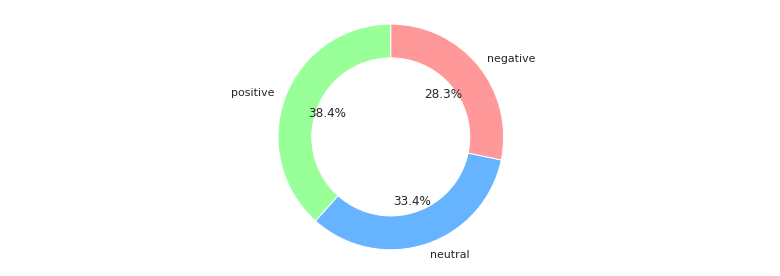

In [149]:
plot_tweet_sentiment(read_sentiment_file('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

positive    674
neutral     538
negative    386
Name: score, dtype: int64


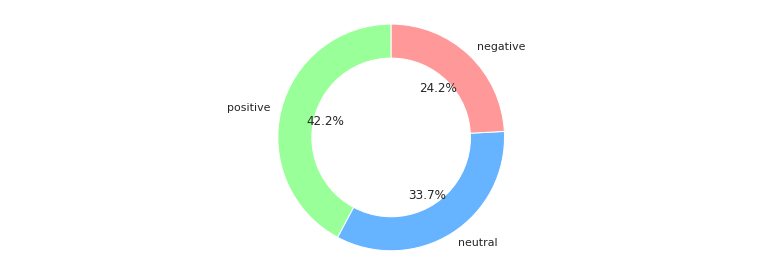

In [150]:
# wplyw user verified

plot_tweet_sentiment(read_sentiment_file_user_verified('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

positive    128
neutral     105
negative     80
Name: score, dtype: int64


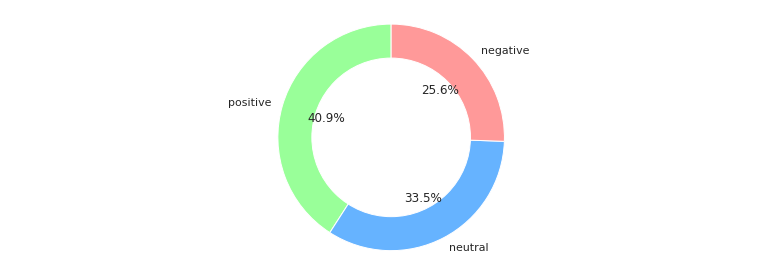

In [151]:
# wplyw liczby followersow

plot_tweet_sentiment(read_sentiment_file_followers('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

positive    3859
neutral     3032
negative    2941
Name: score, dtype: int64


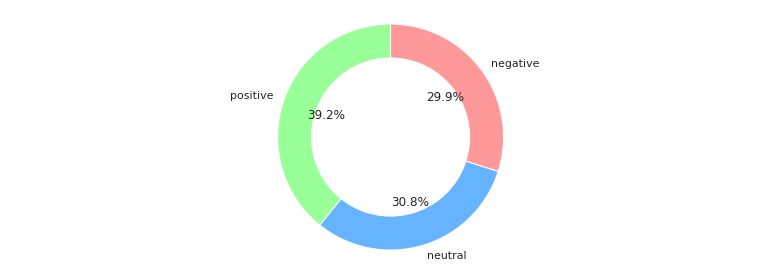

In [152]:
# wplyw location london

plot_tweet_sentiment(read_sentiment_file_location_london('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

positive    65
negative    34
neutral     18
Name: score, dtype: int64


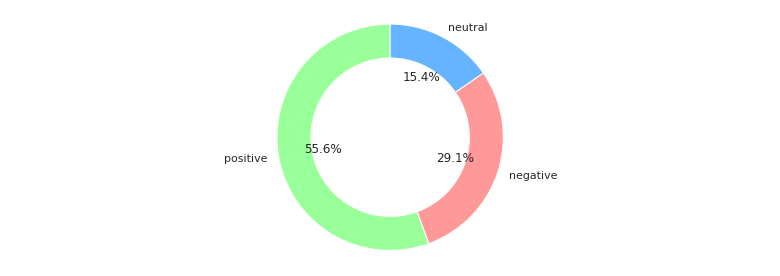

In [153]:
# wplyw likow

plot_tweet_sentiment(read_sentiment_file_likes('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

negative    6665
positive     821
neutral      402
Name: score, dtype: int64


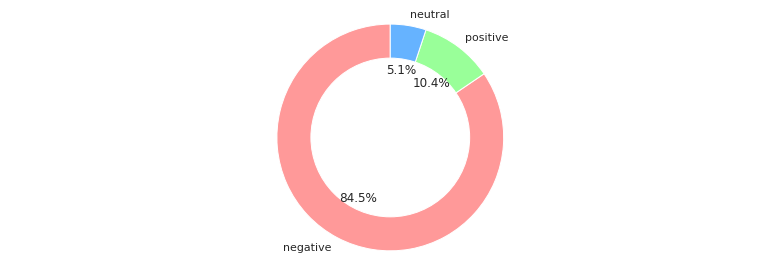

In [154]:
# wplyw retweetow

plot_tweet_sentiment(read_sentiment_file_retweets('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

positive    13989
neutral     11016
negative     8044
Name: score, dtype: int64


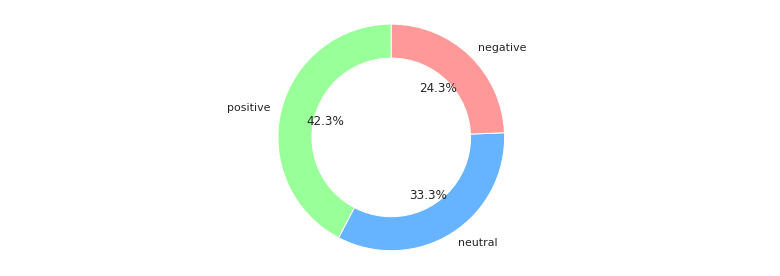

In [155]:
# wplyw retweetow

plot_tweet_sentiment(read_sentiment_file_retweets_low('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

In [156]:
def plot_day_tweet_in_time(data):
    sns.set(rc={'figure.figsize':(11, 4)})

    data['hour'] = pd.to_datetime(data['timestamp']).dt.to_period('H')

    data_pos = data[data['score'] == 'positive']
    data_neg = data[data['score'] == 'negative']
    data_neu = data[data['score'] == 'neutral']
    counts_pos = data_pos['hour'].value_counts().sort_index()
    counts_neg = data_neg['hour'].value_counts().sort_index()
    counts_neu = data_neu['hour'].value_counts().sort_index()

    labels = [str(c) for c in counts_pos.index]
    
    chart = sns.lineplot(x=labels, y=counts_pos.values, color = 'green', label = 'positive')
    sns.lineplot(x=labels, y=counts_neg.values, color = 'red', label = 'negative')
    sns.lineplot(x=labels, y=counts_neu.values, color = 'blue', label = 'neutral')
    chart.set_xticklabels(labels, rotation = 45)

In [157]:
def plot_year_tweet_in_time(data):
    sns.set(rc={'figure.figsize':(11, 4)})

    data['month_year'] = pd.to_datetime(data['timestamp']).dt.to_period('M')

    data_pos = data[data['score'] == 'positive']
    data_neg = data[data['score'] == 'negative']
    data_neu = data[data['score'] == 'neutral']
    counts_pos = data_pos['month_year'].value_counts().sort_index()
    counts_neg = data_neg['month_year'].value_counts().sort_index()
    counts_neu = data_neu['month_year'].value_counts().sort_index()

    labels = [str(c) for c in counts_pos.index]

    chart = sns.lineplot(x=labels, y=counts_pos.values, color = 'green', label = 'positive')
    sns.lineplot(x=labels, y=counts_neg.values, color = 'red', label = 'negative')
    sns.lineplot(x=labels, y=counts_neu.values, color = 'blue', label = 'neutral')
    chart.set_xticklabels(labels, rotation = 45)

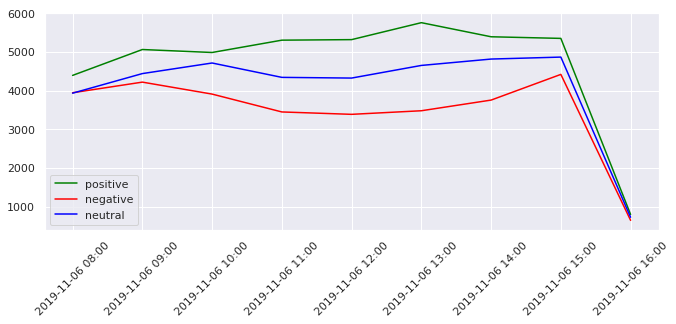

In [159]:
plot_day_tweet_in_time(read_sentiment_file('preprocessed/brexit-keyword-06-11-19-sentiment-data.csv'))

# Nigel Farage timeline 
### period: 11/2018 - 11/2019

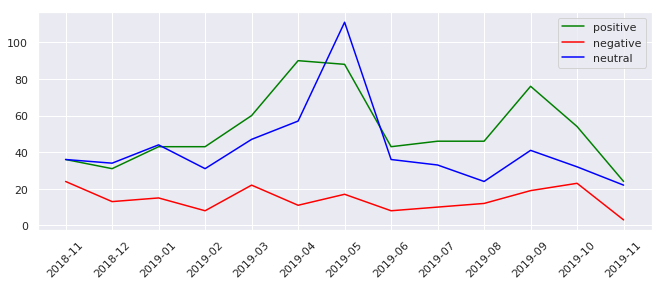

In [160]:
plot_year_tweet_in_time(read_sentiment_file('preprocessed/nigelfarage-timeline-year-sentiment-data.csv'))

positive    680
neutral     548
negative    185
Name: score, dtype: int64


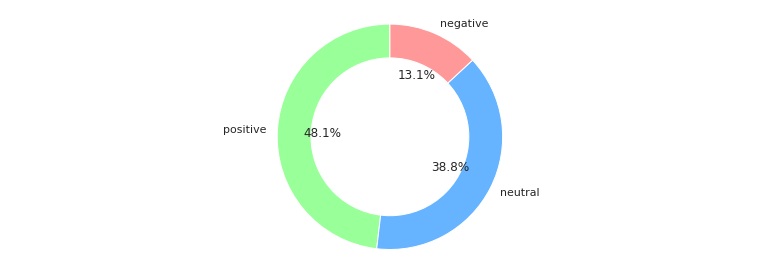

In [162]:
plot_tweet_sentiment(read_sentiment_file('preprocessed/nigelfarage-timeline-year-sentiment-data.csv'))

In [163]:
def plot_monthly_tweet_in_time(data):

    sns.set(rc={'figure.figsize':(11, 4)})


    data['day_month'] = pd.to_datetime(data['timestamp']).dt.to_period('D')
    counts = data['day_month'].value_counts().sort_index()
    sizes = counts.values
    labels = [str(c) for c in counts.index]
    chart = sns.lineplot(x=labels, y=sizes)
    chart.set_xticklabels(labels, rotation = 45)

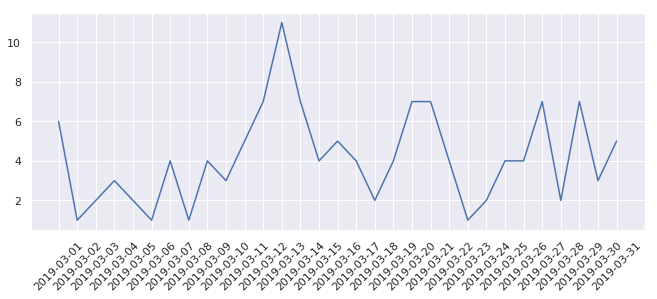

In [167]:
plot_monthly_tweet_in_time(read_sentiment_file_march('preprocessed/nigelfarage-timeline-year-sentiment-data.csv'))

# Nigel Farage single tweet responses

neutral     265
positive    201
negative    118
Name: score, dtype: int64


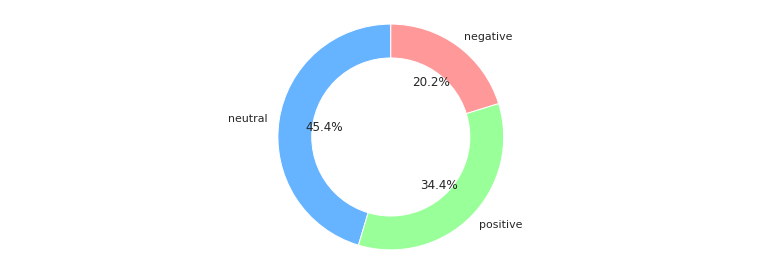

In [169]:
plot_tweet_sentiment(read_sentiment_file('preprocessed/1187647526285008896_responses-sentiment-data.csv'))